In [ ]:
#  1. Import Libraries
# ========================
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [3]:
#  2. Download EU Data
# ==========================
tickers = ['SAP.DE', '^STOXX50E', '^GDAXI']  # SAP, EU Index, DAX, EU Volatility
start_date = "2015-01-01"
end_date = "2024-12-31"

data = yf.download(tickers, start=start_date, end=end_date)
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]
data = data.ffill()

[*********************100%***********************]  3 of 3 completed


In [ ]:
# 3. Feature Engineering + Target Creation
# ============================================
def get_diff_label(df, open_col, close_col, threshold=0.004):
    diff = (df[close_col] - df[open_col]) / df[open_col]
    return np.select([diff > threshold, diff < -threshold], [1, -1], default=0)

def get_diff_to_avg(df, col, window):
    return ((df[col] - df[col].rolling(window=window).mean()) / df[col]) * 100

def get_pct_change_lastday(df, col):
    return df[col].pct_change().shift(1) * 100

def get_data_lastday(df, col):
    return df[col].shift(1)

In [6]:
# Build feature dataframe
df = pd.DataFrame()
df['sap_diff_lastnight'] = data['Open_SAP.DE'] - data['Close_SAP.DE'].shift(1)
df['sap_pct_change'] = (data['Close_SAP.DE'] - data['Open_SAP.DE']) / data['Open_SAP.DE'] * 100

# Moving average differences
for window in [5, 10, 20, 60]:
    df[f'sap_diff_to_{window}d_avg'] = (data['Open_SAP.DE'] - data['Open_SAP.DE'].rolling(window).mean()) / data['Open_SAP.DE'] * 100

# EU indices
df['dax_change_lastday'] = data['Close_^GDAXI'].pct_change().shift(1) * 100
df['stoxx50e_change'] = data['Close_^STOXX50E'].pct_change().shift(1) * 100


In [7]:
# Target label
df['label'] = get_diff_label(data, 'Open_SAP.DE', 'Close_SAP.DE')

In [8]:
# Drop missing rows
df = df.dropna()

In [ ]:
#  4. Train/Test Split
# =========================
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# 5. Train ML Model
# =========================
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc:.2%}")

Model Accuracy: 100.00%


In [12]:
# 💰 6. Simulate Trading Strategy (Safe Version)
# ==============================================

# Match prediction DataFrame to y_test by index
df_test = df.loc[y_test.index].copy()
df_test['pred'] = y_pred

# Get matching prices safely
open_price = data['Open_SAP.DE'].reindex(df_test.index)
close_price = data['Close_SAP.DE'].reindex(df_test.index)
actual_diff = close_price - open_price

# Initialize capital simulation
capital = 1000
capital_list = [capital]

# Run simulation
for pred, cost, diff in zip(df_test['pred'], open_price, actual_diff):
    if pd.isna(cost) or pd.isna(diff):
        capital_list.append(capital)  # skip day if data missing
        continue

    if pred == 0:
        capital_list.append(capital)
    else:
        daily_return = pred * diff / cost
        capital *= (1 + daily_return)
        capital_list.append(capital)

# Calculate APY
n_days = len(df_test)
final_return = capital_list[-1]
apy = (final_return / capital_list[0]) ** (240 / n_days) - 1

# Output results
print(f"\n✅ Final Capital: €{final_return:.2f}")
print(f"📈 Estimated Annualized Return (APY): {apy:.2%}")



✅ Final Capital: €46046.63
📈 Estimated Annualized Return (APY): 533.20%


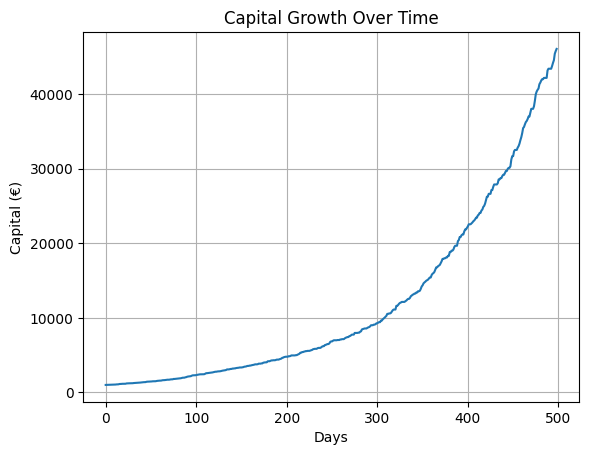

In [13]:
#  7. Plot Capital Over Time
# =======================
plt.plot(capital_list)
plt.title("Capital Growth Over Time")
plt.xlabel("Days")
plt.ylabel("Capital (€)")
plt.grid()
plt.show()